### Display the versions of the libraries used for reference purposes.

In [44]:
import sys
import numpy as np
import tensorflow as tf
import sklearn
import torch
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import notebook
import os

# Print Python version
print(f'Python version: {sys.version}')

# Print Jupyter Notebook version
print(f'Jupyter Notebook version: {notebook.__version__}')

# Print library versions
print(f'NumPy version: {np.__version__}')
print(f'TensorFlow version: {tf.__version__}')
print(f'Torch version: {torch.__version__}')
print(f'Scikit-learn version: {sklearn.__version__}')

os.makedirs("mnist_blackbox", exist_ok=True)

Python version: 3.12.9 | packaged by Anaconda, Inc. | (main, Feb  6 2025, 18:49:16) [MSC v.1929 64 bit (AMD64)]
Jupyter Notebook version: 7.3.2
NumPy version: 2.0.1
TensorFlow version: 2.19.0
Torch version: 2.6.0+cu126
Scikit-learn version: 1.6.1


### Loading MNIST dataset and Splitting data and saving them

In [46]:
from sklearn.datasets      import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib

# -------------------------
# 1. Load and Preprocess the MNIST Data
# -------------------------
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.values      # shape (70000, 784)
y = mnist.target.astype(int).values

# 2. Split into train/test
X_train_not_scaled, X_test_not_scaled, \
y_train_not_scaled, y_test_not_scaled = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# 3. Save the raw (unscaled) splits
joblib.dump(
    (X_train_not_scaled, X_test_not_scaled,
     y_train_not_scaled, y_test_not_scaled),
    'Models and Data splits/data_[ORIGINAL] Train_Test_Splits.pkl'
)

# 4. [0,1] Min–Max scaling (divide by 255)
X_train_scaled = X_train_not_scaled / 255.0
X_test_scaled  = X_test_not_scaled  / 255.0
joblib.dump(
    (X_train_scaled, X_test_scaled,
     y_train_not_scaled, y_test_not_scaled),
    'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl'
)

# 5. Standard scaling (zero-mean, unit-variance)
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train_not_scaled)  # fit only on train
X_test_std  = scaler.transform(X_test_not_scaled)       # apply to test

# Save the standardized splits
joblib.dump(
    (X_train_std, X_test_std,
     y_train_not_scaled, y_test_not_scaled),
    'Models and Data splits/data_[STANDARDIZED] Train_Test_Splits.pkl'
)

# (Optional) Save the scaler itself for later inference
joblib.dump(
    scaler,
    'Models and Data splits/standard_scaler.pkl'
)

['Models and Data splits/standard_scaler.pkl']

## Training MLP with ONE hidden layer

### 32 nuerons

In [49]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Loading the scaled MNIST Data
# -------------------------

X_train_np, X_test_np, y_train_np, y_test_np = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------
# Define the MLP Model using PyTorch
# -------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLP(input_dim=X_train.shape[1], hidden_units=32, output_dim=10)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Train the Model
# -------------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# -------------------------
# Evaluate the Model on the Test Data
# -------------------------
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------")

# Compute the confusion matrix and false positives per class
cm = confusion_matrix(y_true, y_pred)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP1L_32.pt')


Epoch [1/100], Loss: 0.4745
Epoch [10/100], Loss: 0.0897
Epoch [20/100], Loss: 0.0508
Epoch [30/100], Loss: 0.0314
Epoch [40/100], Loss: 0.0204
Epoch [50/100], Loss: 0.0130
Epoch [60/100], Loss: 0.0085
Epoch [70/100], Loss: 0.0064
Epoch [80/100], Loss: 0.0055
Epoch [90/100], Loss: 0.0022
Epoch [100/100], Loss: 0.0009

Accuracy: 0.9641
Precision: 0.9639
Recall: 0.9638
F1 Score: 0.9638
--------------
Confusion Matrix:
 [[1358    0    4    0    1    7    4    1    4    2]
 [   0 1548    7    7    0    1    0    6    5    1]
 [   5    7 1343   11    2    7    4    7    9    3]
 [   2    4   15 1368    2   18    1    5   11    2]
 [   2    2    6    1 1296    4    8    5    5   36]
 [   3    1    1   13    2 1203   13    2   13   12]
 [  10    2    2    2    6    6 1343    0    3    1]
 [   2    4   10    6    5    0    0 1411    3   18]
 [   4    3    8   15    5   15    6    5 1293   11]
 [   3    6    0    9   11    5    1   12    9 1335]]
False Alarms for each class: [31 29 53 64 34 63 

### 64 nuerons

In [51]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Loading the scaled MNIST Data
# -------------------------

X_train_np, X_test_np, y_train_np, y_test_np = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------
# Define the MLP Model using PyTorch
# -------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLP(input_dim=X_train.shape[1], hidden_units=64, output_dim=10)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Train the Model
# -------------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# -------------------------
# Evaluate the Model on the Test Data
# -------------------------
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------")

# Compute the confusion matrix and false positives per class
cm = confusion_matrix(y_true, y_pred)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP1L_64.pt')


Epoch [1/100], Loss: 0.4062
Epoch [10/100], Loss: 0.0501
Epoch [20/100], Loss: 0.0165
Epoch [30/100], Loss: 0.0068
Epoch [40/100], Loss: 0.0068
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0073
Epoch [70/100], Loss: 0.0002
Epoch [80/100], Loss: 0.0102
Epoch [90/100], Loss: 0.0001
Epoch [100/100], Loss: 0.0001

Accuracy: 0.9764
Precision: 0.9762
Recall: 0.9763
F1 Score: 0.9762
--------------
Confusion Matrix:
 [[1373    1    0    0    0    3    0    0    2    2]
 [   0 1552    8    2    0    3    1    4    4    1]
 [   6    7 1358    5    3    3    3    5    6    2]
 [   2    1    6 1381    0   14    0    9    9    6]
 [   2    0    5    0 1330    1    5    1    1   20]
 [   3    2    1    5    3 1227    9    1    7    5]
 [   5    1    0    1    5    5 1355    0    3    0]
 [   3    3    7    5    7    1    1 1411    3   18]
 [   4    4    4    5    0    9    4    4 1324    7]
 [   2    4    1    4    7    2    1    7    5 1358]]
False Alarms for each class: [27 23 32 27 25 41 

### 128 nuerons

In [53]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Loading the scaled MNIST Data
# -------------------------

X_train_np, X_test_np, y_train_np, y_test_np = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------
# Define the MLP Model using PyTorch
# -------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLP(input_dim=X_train.shape[1], hidden_units=128, output_dim=10)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Train the Model
# -------------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# -------------------------
# Evaluate the Model on the Test Data
# -------------------------
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------")

# Compute the confusion matrix and false positives per class
cm = confusion_matrix(y_true, y_pred)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP1L_128.pt')


Epoch [1/100], Loss: 0.3452
Epoch [10/100], Loss: 0.0225
Epoch [20/100], Loss: 0.0049
Epoch [30/100], Loss: 0.0011
Epoch [40/100], Loss: 0.0005
Epoch [50/100], Loss: 0.0003
Epoch [60/100], Loss: 0.0001
Epoch [70/100], Loss: 0.0006
Epoch [80/100], Loss: 0.0002
Epoch [90/100], Loss: 0.0040
Epoch [100/100], Loss: 0.0000

Accuracy: 0.9803
Precision: 0.9801
Recall: 0.9801
F1 Score: 0.9801
--------------
Confusion Matrix:
 [[1375    1    1    0    0    0    0    0    3    1]
 [   0 1560    5    2    2    0    0    4    2    0]
 [   4    2 1369    4    2    1    2    5    7    2]
 [   1    2    9 1392    0   12    0    5    4    3]
 [   2    0    4    0 1328    0    7    3    0   21]
 [   4    1    0    7    2 1231    8    0    6    4]
 [   5    0    2    1    5    4 1356    0    2    0]
 [   2    3    7    3    6    1    0 1426    1   10]
 [   7    3    5    5    0    6    2    0 1330    7]
 [   0    3    1    4    6    5    1   10    4 1357]]
False Alarms for each class: [25 15 34 26 23 29 

### 256 nuerons

In [55]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Loading the scaled MNIST Data
# -------------------------

X_train_np, X_test_np, y_train_np, y_test_np = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
X_test = torch.tensor(X_test_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.long).to(device)
y_test = torch.tensor(y_test_np, dtype=torch.long).to(device)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------
# Define the MLP Model using PyTorch
# -------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

model = MLP(input_dim=X_train.shape[1], hidden_units=256, output_dim=10)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Train the Model
# -------------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# -------------------------
# Evaluate the Model on the Test Data
# -------------------------
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------")

# Compute the confusion matrix and false positives per class
cm = confusion_matrix(y_true, y_pred)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP1L_256.pt')


Epoch [1/100], Loss: 0.3059
Epoch [10/100], Loss: 0.0139
Epoch [20/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0023
Epoch [40/100], Loss: 0.0014
Epoch [50/100], Loss: 0.0000
Epoch [60/100], Loss: 0.0008
Epoch [70/100], Loss: 0.0008
Epoch [80/100], Loss: 0.0000
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0030

Accuracy: 0.9809
Precision: 0.9808
Recall: 0.9808
F1 Score: 0.9808
--------------
Confusion Matrix:
 [[1368    1    1    1    0    2    0    2    2    4]
 [   0 1562    5    1    1    0    0    5    1    0]
 [   4    4 1364    6    2    2    2    5    7    2]
 [   2    2    9 1391    0   16    0    3    5    0]
 [   3    2    2    0 1337    0    7    2    0   12]
 [   2    1    0    3    2 1236    5    0   10    4]
 [   4    3    0    1    2    4 1360    0    1    0]
 [   1    3   13    1    5    0    0 1428    2    6]
 [   7    2    3    7    1    5    6    1 1330    3]
 [   0    2    0    5    7    5    0   11    4 1357]]
False Alarms for each class: [23 20 33 25 20 34 

## Training MLP with TWO hidden layer

## 32 nuerons

In [58]:
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Loading the scaled MNIST Data
# -------------------------
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load( 'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')


# Convert the numpy arrays to torch tensors and send them to the GPU (if available)
# Ensure feature data are floats and labels are of long type for classification.
X_train = torch.from_numpy(X_train_np).float().to(device)
X_test = torch.from_numpy(X_test_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
y_test = torch.from_numpy(y_test_np).long().to(device)

# Create a Dataset and DataLoader for the training data
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the MLP model using PyTorch's nn.Module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        # Second hidden layer
        self.fc2 = nn.Linear(256, hidden_units)
        # Output layer
        self.out = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Apply first layer and activation
        x = torch.relu(self.fc1(x))
        # Second layer and activation
        x = torch.relu(self.fc2(x))
        # Note: Do not apply softmax here when using CrossEntropyLoss.
        x = self.out(x)
        return x

# Model hyperparameters
input_dim = X_train.shape[1]
hidden_units = 32
output_dim = 10  # adjust based on your problem's number of classes

# Instantiate and move the model to the GPU
model = MLP(input_dim, hidden_units, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on the test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    # Get the predicted classes from the logits
    _, y_pred_tensor = torch.max(test_outputs, 1)
    # Bring tensors back to cpu and convert to numpy arrays for scikit-learn metrics
    y_pred = y_pred_tensor.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average='macro')
recall = recall_score(y_test_np, y_pred, average='macro')
f1 = f1_score(y_test_np, y_pred, average='macro')

print(f"\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("------------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Calculate false alarms for each class 
# (sum of column values except the diagonal elements)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP2L_32.pt')


Using device: cuda
Epoch [1/100], Loss: 0.3390
Epoch [10/100], Loss: 0.0145
Epoch [20/100], Loss: 0.0104
Epoch [30/100], Loss: 0.0038
Epoch [40/100], Loss: 0.0063
Epoch [50/100], Loss: 0.0042
Epoch [60/100], Loss: 0.0034
Epoch [70/100], Loss: 0.0009
Epoch [80/100], Loss: 0.0022
Epoch [90/100], Loss: 0.0015
Epoch [100/100], Loss: 0.0013

Evaluation Metrics:
Accuracy: 0.9785
Precision: 0.9784
Recall: 0.9784
F1 Score: 0.9783
------------------------
Confusion Matrix:
 [[1356    0    3    1    0    2    6    1   10    2]
 [   0 1555    4    1    1    2    0    4    8    0]
 [   0    2 1381    2    2    1    1    1    7    1]
 [   0    0    9 1385    1    9    0    8   15    1]
 [   1    0    4    0 1346    1    5    0    0    8]
 [   3    0    1    3    1 1236    8    2    7    2]
 [   3    3    2    1    4    5 1352    0    5    0]
 [   1    3   12    0    9    1    0 1426    3    4]
 [   0    1    2    5    0    6    2    1 1348    0]
 [   0    5    0    4   44    5    0   10    9 1314]]

### 64 Nuerons

In [60]:
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Loading the scaled MNIST Data
# -------------------------
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load( 'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')


# Convert the numpy arrays to torch tensors and send them to the GPU (if available)
# Ensure feature data are floats and labels are of long type for classification.
X_train = torch.from_numpy(X_train_np).float().to(device)
X_test = torch.from_numpy(X_test_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
y_test = torch.from_numpy(y_test_np).long().to(device)

# Create a Dataset and DataLoader for the training data
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the MLP model using PyTorch's nn.Module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        # Second hidden layer
        self.fc2 = nn.Linear(256, hidden_units)
        # Output layer
        self.out = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Apply first layer and activation
        x = torch.relu(self.fc1(x))
        # Second layer and activation
        x = torch.relu(self.fc2(x))
        # Note: Do not apply softmax here when using CrossEntropyLoss.
        x = self.out(x)
        return x

# Model hyperparameters
input_dim = X_train.shape[1]
hidden_units = 64
output_dim = 10  # adjust based on your problem's number of classes

# Instantiate and move the model to the GPU
model = MLP(input_dim, hidden_units, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on the test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    # Get the predicted classes from the logits
    _, y_pred_tensor = torch.max(test_outputs, 1)
    # Bring tensors back to cpu and convert to numpy arrays for scikit-learn metrics
    y_pred = y_pred_tensor.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average='macro')
recall = recall_score(y_test_np, y_pred, average='macro')
f1 = f1_score(y_test_np, y_pred, average='macro')

print(f"\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("------------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Calculate false alarms for each class 
# (sum of column values except the diagonal elements)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP2L_64.pt')


Using device: cuda
Epoch [1/100], Loss: 0.3116
Epoch [10/100], Loss: 0.0154
Epoch [20/100], Loss: 0.0069
Epoch [30/100], Loss: 0.0050
Epoch [40/100], Loss: 0.0070
Epoch [50/100], Loss: 0.0050
Epoch [60/100], Loss: 0.0059
Epoch [70/100], Loss: 0.0049
Epoch [80/100], Loss: 0.0024
Epoch [90/100], Loss: 0.0000
Epoch [100/100], Loss: 0.0000

Evaluation Metrics:
Accuracy: 0.9839
Precision: 0.9837
Recall: 0.9838
F1 Score: 0.9837
------------------------
Confusion Matrix:
 [[1373    1    2    0    0    0    0    0    2    3]
 [   0 1558    5    1    0    2    2    5    1    1]
 [   2    0 1377    5    3    0    3    3    4    1]
 [   1    0    7 1397    0    9    0    5    7    2]
 [   1    0    2    0 1335    0    3    2    2   20]
 [   3    1    0    5    1 1234   10    0    5    4]
 [   5    0    0    0    3    3 1362    0    2    0]
 [   1    3    8    0    8    0    0 1431    1    7]
 [   2    2    3    6    0    3    3    1 1342    3]
 [   1    4    0    2    5    4    0    6    4 1365]]

### 128 Nuerons

In [62]:
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Loading the scaled MNIST Data
# -------------------------
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load( 'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')


# Convert the numpy arrays to torch tensors and send them to the GPU (if available)
# Ensure feature data are floats and labels are of long type for classification.
X_train = torch.from_numpy(X_train_np).float().to(device)
X_test = torch.from_numpy(X_test_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
y_test = torch.from_numpy(y_test_np).long().to(device)

# Create a Dataset and DataLoader for the training data
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the MLP model using PyTorch's nn.Module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        # Second hidden layer
        self.fc2 = nn.Linear(256, hidden_units)
        # Output layer
        self.out = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Apply first layer and activation
        x = torch.relu(self.fc1(x))
        # Second layer and activation
        x = torch.relu(self.fc2(x))
        # Note: Do not apply softmax here when using CrossEntropyLoss.
        x = self.out(x)
        return x

# Model hyperparameters
input_dim = X_train.shape[1]
hidden_units = 128
output_dim = 10  # adjust based on your problem's number of classes

# Instantiate and move the model to the GPU
model = MLP(input_dim, hidden_units, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on the test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    # Get the predicted classes from the logits
    _, y_pred_tensor = torch.max(test_outputs, 1)
    # Bring tensors back to cpu and convert to numpy arrays for scikit-learn metrics
    y_pred = y_pred_tensor.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average='macro')
recall = recall_score(y_test_np, y_pred, average='macro')
f1 = f1_score(y_test_np, y_pred, average='macro')

print(f"\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("------------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Calculate false alarms for each class 
# (sum of column values except the diagonal elements)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP2L_128.pt')


Using device: cuda
Epoch [1/100], Loss: 0.2848
Epoch [10/100], Loss: 0.0156
Epoch [20/100], Loss: 0.0071
Epoch [30/100], Loss: 0.0025
Epoch [40/100], Loss: 0.0062
Epoch [50/100], Loss: 0.0088
Epoch [60/100], Loss: 0.0018
Epoch [70/100], Loss: 0.0036
Epoch [80/100], Loss: 0.0019
Epoch [90/100], Loss: 0.0023
Epoch [100/100], Loss: 0.0052

Evaluation Metrics:
Accuracy: 0.9818
Precision: 0.9817
Recall: 0.9816
F1 Score: 0.9817
------------------------
Confusion Matrix:
 [[1377    1    0    0    0    0    2    0    1    0]
 [   0 1556    4    6    1    0    1    6    1    0]
 [   5    0 1380    3    2    0    1    5    1    1]
 [   1    0   11 1398    0    5    0    2    7    4]
 [   1    4    2    1 1339    0    6    0    1   11]
 [   5    0    0   15    2 1221   10    0    6    4]
 [   6    1    1    0    1    2 1363    0    1    0]
 [   2    3   13    2    6    0    0 1423    2    8]
 [   5    2    2    3    1    5    7    1 1335    4]
 [   2    5    0    2   17    3    2    5    2 1353]]

### 256 nuerons

In [64]:
import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# -------------------------
# Loading the scaled MNIST Data
# -------------------------
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load( 'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')


# Convert the numpy arrays to torch tensors and send them to the GPU (if available)
# Ensure feature data are floats and labels are of long type for classification.
X_train = torch.from_numpy(X_train_np).float().to(device)
X_test = torch.from_numpy(X_test_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
y_test = torch.from_numpy(y_test_np).long().to(device)

# Create a Dataset and DataLoader for the training data
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the MLP model using PyTorch's nn.Module
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        # First hidden layer
        self.fc1 = nn.Linear(input_dim, 256)
        # Second hidden layer
        self.fc2 = nn.Linear(256, hidden_units)
        # Output layer
        self.out = nn.Linear(hidden_units, output_dim)
        
    def forward(self, x):
        # Apply first layer and activation
        x = torch.relu(self.fc1(x))
        # Second layer and activation
        x = torch.relu(self.fc2(x))
        # Note: Do not apply softmax here when using CrossEntropyLoss.
        x = self.out(x)
        return x

# Model hyperparameters
input_dim = X_train.shape[1]
hidden_units = 256
output_dim = 10  # adjust based on your problem's number of classes

# Instantiate and move the model to the GPU
model = MLP(input_dim, hidden_units, output_dim).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Evaluation on the test data
model.eval()
with torch.no_grad():
    test_outputs = model(X_test)
    # Get the predicted classes from the logits
    _, y_pred_tensor = torch.max(test_outputs, 1)
    # Bring tensors back to cpu and convert to numpy arrays for scikit-learn metrics
    y_pred = y_pred_tensor.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    
# Calculate evaluation metrics
accuracy = accuracy_score(y_test_np, y_pred)
precision = precision_score(y_test_np, y_pred, average='macro')
recall = recall_score(y_test_np, y_pred, average='macro')
f1 = f1_score(y_test_np, y_pred, average='macro')

print(f"\nEvaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("------------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test_np, y_pred)

# Calculate false alarms for each class 
# (sum of column values except the diagonal elements)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())

# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP2L_256.pt')


Using device: cuda
Epoch [1/100], Loss: 0.2693
Epoch [10/100], Loss: 0.0172
Epoch [20/100], Loss: 0.0123
Epoch [30/100], Loss: 0.0065
Epoch [40/100], Loss: 0.0054
Epoch [50/100], Loss: 0.0023
Epoch [60/100], Loss: 0.0034
Epoch [70/100], Loss: 0.0022
Epoch [80/100], Loss: 0.0049
Epoch [90/100], Loss: 0.0047
Epoch [100/100], Loss: 0.0000

Evaluation Metrics:
Accuracy: 0.9836
Precision: 0.9836
Recall: 0.9835
F1 Score: 0.9835
------------------------
Confusion Matrix:
 [[1377    1    1    0    0    0    1    0    1    0]
 [   1 1557    5    5    1    0    1    4    1    0]
 [   3    2 1377    2    0    1    1    7    4    1]
 [   0    0    5 1401    0   10    0    3    8    1]
 [   1    4    2    0 1334    0    5    0    0   19]
 [   2    0    3    3    1 1228   10    2    8    6]
 [   2    2    0    1    3    5 1361    0    1    0]
 [   2    3    6    1   10    0    1 1433    2    1]
 [   2    4    2    2    1    1    4    1 1341    7]
 [   2    2    0    5    9    2    1    5    3 1362]]

### CNN plus 2 dense layer

In [66]:
import os
import random

import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load data (X_train, X_test, y_train, y_test) from pickle
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load(
    'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl'
)

# 3. Reshape data for PyTorch CNN: from (N, 28, 28, 1) to (N, 1, 28, 28)
N_train = X_train_np.shape[0]
N_test  = X_test_np.shape[0]
X_train_np = X_train_np.reshape(N_train, 1, 28, 28)
X_test_np  = X_test_np.reshape(N_test,  1, 28, 28)

# 4. Convert numpy arrays to torch tensors, move them to device
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
X_test  = torch.from_numpy(X_test_np).float().to(device)
y_test  = torch.from_numpy(y_test_np).long().to(device)

# 5. Create DataLoader for the training data
batch_size   = 64
train_ds     = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 6. Define the CNN model with two 256-unit dense layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # conv -> pool
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=3, padding=0)
        self.pool  = nn.MaxPool2d(kernel_size=2)
        # after conv+pool: 32 x 13 x 13 = 5408 dims
        self.fc1   = nn.Linear(32 * 13 * 13, 256)
        self.fc2   = nn.Linear(256,            256)
        self.fc3   = nn.Linear(256,             10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))    # -> (N,32,26,26)
        x = self.pool(x)                 # -> (N,32,13,13)
        x = x.view(x.size(0), -1)        # -> (N,5408)
        x = torch.relu(self.fc1(x))      # -> (N,256)
        x = torch.relu(self.fc2(x))      # -> (N,256)
        x = self.fc3(x)                  # -> (N,10) logits
        return x

model = CNNModel().to(device)

# 7. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 8. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss    = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 9. Evaluation on test set
model.eval()
with torch.no_grad():
    outputs_test = model(X_test)
    _, predicted = torch.max(outputs_test, 1)

y_pred = predicted.cpu().numpy()
y_true = y_test.cpu().numpy()

# 10. Evaluation metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 11. Confusion matrix and false alarms
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

false_alarms = cm.sum(axis=0) - np.diag(cm)
print("\nFalse Alarms per class:", false_alarms)
print("Total False Alarms    :", false_alarms.sum())

# 12. Save the scripted model
scripted = torch.jit.script(model)
torch.jit.save(scripted, 'Models and Data splits/model_CNN.pt')


Using device: cuda
Epoch [1/100], Loss: 0.2283
Epoch [11/100], Loss: 0.0053
Epoch [21/100], Loss: 0.0032
Epoch [31/100], Loss: 0.0010
Epoch [41/100], Loss: 0.0017
Epoch [51/100], Loss: 0.0026
Epoch [61/100], Loss: 0.0000
Epoch [71/100], Loss: 0.0000
Epoch [81/100], Loss: 0.0000
Epoch [91/100], Loss: 0.0000

Evaluation Metrics:
Accuracy : 0.9894
Precision: 0.9894
Recall   : 0.9894
F1 Score : 0.9894

Confusion Matrix:
[[1376    1    1    0    0    0    1    0    2    0]
 [   0 1563    3    1    3    0    0    4    1    0]
 [   1    0 1382    4    1    0    1    7    2    0]
 [   1    0    0 1412    0    7    0    3    4    1]
 [   2    3    1    0 1343    0    1    0    0   15]
 [   1    0    0    3    0 1250    3    1    3    2]
 [   4    2    0    0    4    1 1362    0    2    0]
 [   2    2    2    0    1    0    0 1446    0    6]
 [   1    0    2    3    1    2    5    0 1349    2]
 [   0    3    0    1    5    4    0    7    2 1369]]

False Alarms per class: [12 11  9 12 15 14 11 22

### KNN with k=5

In [1]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Loading the pre-split data
X_train, X_test, y_train, y_test = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

# Define the kNN model
model = KNeighborsClassifier(n_neighbors=5)  # You can tune n_neighbors

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# False alarms for each class (sum of columns except the diagonal)
false_alarms = cm.sum(axis=0) - np.diagonal(cm)

# Print false alarms for each class
print("False alarms for each class:", false_alarms)
print("False alarms for all classes:", false_alarms.sum())

# Saving the model
joblib.dump(model, 'Models and Data splits/model_kNN.pkl')


Accuracy: 0.9696
Precision: 0.9701
Recall: 0.9692
F1 Score: 0.9695
--------------------
Confusion Matrix:
 [[1375    1    0    0    0    1    3    0    0    1]
 [   0 1564    5    1    1    0    1    3    0    0]
 [  12   14 1335    4    2    0    4   24    3    0]
 [   1    2    7 1386    0   12    2    9    6    3]
 [   2   15    1    0 1306    0    5    1    0   35]
 [   6    3    1    7    1 1217   17    2    3    6]
 [   7    3    0    0    1    8 1355    0    1    0]
 [   1   17    3    0    2    1    0 1423    0   12]
 [   8   12    1   22    4   29    4    4 1275    6]
 [   2    8    1   13   11    1    1   13    2 1339]]
False alarms for each class: [39 75 19 47 22 52 37 56 15 63]
False alarms for all classes: 425


['Models and Data splits/model_kNN.pkl']

### Support Vector Machines

In [70]:
from sklearn.svm import SVC
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Loading the pre-split data for reference 
X_train, X_test, y_train, y_test = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

# Define the SVM model
model = SVC(kernel='rbf', C=1.0, gamma='scale')  # You can change kernel='linear' or 'poly' as needed

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# False alarms for each class (sum of columns except the diagonal)
false_alarms = cm.sum(axis=0) - np.diagonal(cm)

# Print false alarms for each class
print("False alarms for each class:", false_alarms)
print("False alarms for all classes:", false_alarms.sum())

# Saving the model
joblib.dump(model, 'Models and Data splits/model_SVM.pkl')


Accuracy: 0.9791
Precision: 0.9790
Recall: 0.9789
F1 Score: 0.9790
--------------------
Confusion Matrix:
 [[1374    1    0    0    0    2    1    0    2    1]
 [   0 1559    6    3    0    0    0    4    2    1]
 [   6    1 1370    2    3    0    3    7    5    1]
 [   2    2   10 1384    0   10    0    9   10    1]
 [   2    3    3    0 1328    0    5    1    1   22]
 [   3    0    1    8    2 1233    8    0    5    3]
 [   7    1    3    0    2    2 1357    0    3    0]
 [   2    4    9    0    8    0    0 1424    1   11]
 [   3    2    5    4    2    7    3    1 1334    4]
 [   4    6    0    7   13    1    1   10    5 1344]]
False alarms for each class: [29 20 37 24 30 22 21 32 34 44]
False alarms for all classes: 293


['Models and Data splits/model_SVM.pkl']

### XGBoost

In [74]:
from xgboost import XGBClassifier
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

# Loading the pre-split data for reference 
X_train, X_test, y_train, y_test = joblib.load('Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

# Define the XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', verbosity=0)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# False alarms for each class (sum of columns except the diagonal)
false_alarms = cm.sum(axis=0) - np.diagonal(cm)

# Print false alarms for each class
print("False alarms for each class:", false_alarms)
print("False alarms for all classes:", false_alarms.sum())

# Saving the model 
joblib.dump(model, 'Models and Data splits/model_XGB.pkl')


Accuracy: 0.9766
Precision: 0.9765
Recall: 0.9764
F1 Score: 0.9764
--------------------
Confusion Matrix:
 [[1372    1    1    1    1    0    2    0    2    1]
 [   0 1555    8    3    1    0    1    6    1    0]
 [   6    0 1366    5    4    0    5    6    6    0]
 [   2    1    8 1386    0    8    0   12    6    5]
 [   4    5    3    0 1326    0    6    1    1   19]
 [   3    1    1   10    0 1223   13    1    5    6]
 [   7    2    0    0    3    6 1354    0    3    0]
 [   2    4    6    1    5    0    0 1427    3   11]
 [   3    3    4    4    2    4    6    0 1329   10]
 [   5    7    0    6   14    4    1    9   11 1334]]
False alarms for each class: [32 24 31 30 30 22 34 35 38 52]
False alarms for all classes: 328


['Models and Data splits/model_XGBoost.pkl']

### RF with 100 Decision Trees

In [76]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib
from sklearn.metrics import confusion_matrix

 
# Loading the pre-split data for reference 
X_train, X_test, y_train, y_test = joblib.load( 'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')


# Define the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)


# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # 'macro' averages for multi-class classification
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Print evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("-----------------------")

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# False alarms for each class (sum of columns except the diagonal)
false_alarms = cm.sum(axis=0) - np.diagonal(cm)

print("Confusion Matrix:\n", cm)

# Print false alarms for each class
print("False Alarms for each class:", false_alarms)

print("False Alarms for all classes:", false_alarms.sum())

#Saving the train and test sets 
joblib.dump(model, 'Models and Data splits/model_RF.pkl')


Accuracy: 0.9672
Precision: 0.9670
Recall: 0.9669
F1 Score: 0.9669
-----------------------
Confusion Matrix:
 [[1371    1    0    0    1    0    2    0    5    1]
 [   0 1548    9    7    1    1    2    5    1    1]
 [   8    1 1350    3    6    1    7   14    7    1]
 [   3    1   14 1368    0   14    2   12   12    2]
 [   4    3    1    0 1312    0   10    0    4   31]
 [   5    1    2   17    3 1207   11    2    7    8]
 [   9    2    1    0    3    4 1350    0    6    0]
 [   1    5   13    0    9    0    0 1414    3   14]
 [   3    3    8    7    3   11    3    0 1308   19]
 [   8    7    1   16   18    4    1   12   11 1313]]
False Alarms for each class: [41 24 49 50 44 35 38 45 56 77]
False Alarms for all classes: 459


['Models and Data splits/model_RF.pkl']

# Onwards; StandardScaler instead of [0,1]

### MLP1L with StandardScaler

In [79]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import random
import joblib
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    # Optional: for determinism (may impact performance)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# -------------------------
# Loading the scaled MNIST Data
# -------------------------

X_train_np, X_test_np, y_train_np, y_test_np = joblib.load( 'Models and Data splits/data_[STANDARDIZED] Train_Test_Splits.pkl')


# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train_np, dtype=torch.float32)
X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.long)
y_test = torch.tensor(y_test_np, dtype=torch.long)

# Create DataLoaders for mini-batch training
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# -------------------------
# Define the MLP Model using PyTorch
# -------------------------
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_units, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        # The output logits will be used in the CrossEntropyLoss, so no softmax here
        x = self.fc2(x)
        return x

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=X_train.shape[1], hidden_units=256, output_dim=10)
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------
# Train the Model
# -------------------------
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_X, batch_y in train_loader:
        # Move data to GPU if available
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

# -------------------------
# Evaluate the Model on the Test Data
# -------------------------
model.eval()
all_preds = []
all_true = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        # Get predicted class using the index with maximum logit score
        _, predicted = torch.max(outputs, 1)
        all_preds.append(predicted.cpu().numpy())
        all_true.append(batch_y.cpu().numpy())

y_pred = np.concatenate(all_preds)
y_true = np.concatenate(all_true)

# Compute evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("--------------")

# Compute the confusion matrix and false positives per class
cm = confusion_matrix(y_true, y_pred)
false_alarms = cm.sum(axis=0) - np.diag(cm)

print("Confusion Matrix:\n", cm)
print("False Alarms for each class:", false_alarms)
print("False Alarms for all classes:", false_alarms.sum())



# Save the scripted model
model = torch.jit.script(model)
torch.jit.save(model, 'Models and Data splits/model_MLP1LSca.pt')


Epoch [1/100], Loss: 0.2215
Epoch [10/100], Loss: 0.0307
Epoch [20/100], Loss: 0.0163
Epoch [30/100], Loss: 0.0090
Epoch [40/100], Loss: 0.0049
Epoch [50/100], Loss: 0.0080
Epoch [60/100], Loss: 0.0201
Epoch [70/100], Loss: 0.0072
Epoch [80/100], Loss: 0.0088
Epoch [90/100], Loss: 0.0045
Epoch [100/100], Loss: 0.0019

Accuracy: 0.9753
Precision: 0.9752
Recall: 0.9752
F1 Score: 0.9751
--------------
Confusion Matrix:
 [[1375    1    0    1    1    1    0    0    1    1]
 [   0 1550    8    3    1    4    1    6    2    0]
 [   7    3 1357    7    1    2    4    5    7    5]
 [   1    1   12 1384    1   12    0   10    4    3]
 [   1    3    2    0 1325    0    6    2    2   24]
 [   3    1    0    6    3 1228    7    3    6    6]
 [   8    2    2    0    2    8 1350    0    3    0]
 [   3    3   11    2    7    2    0 1417    0   14]
 [   3    3    6    9    3   11    6    2 1313    9]
 [   2    4    0    3    7    4    0   15    1 1355]]
False Alarms for each class: [28 21 41 31 26 44 

### CNN with different Scaler

In [81]:
import os
import random

import joblib
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)

# -------------------------
# Set seeds for reproducibility
# -------------------------
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 1. Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Load data (X_train, X_test, y_train, y_test) from pickle
X_train_np, X_test_np, y_train_np, y_test_np = joblib.load(
    'Models and Data splits/data_[STANDARDIZED] Train_Test_Splits.pkl'
)

# 3. Reshape data for PyTorch CNN: from (N, 28, 28, 1) to (N, 1, 28, 28)
N_train = X_train_np.shape[0]
N_test  = X_test_np.shape[0]
X_train_np = X_train_np.reshape(N_train, 1, 28, 28)
X_test_np  = X_test_np.reshape(N_test,  1, 28, 28)

# 4. Convert numpy arrays to torch tensors, move them to device
X_train = torch.from_numpy(X_train_np).float().to(device)
y_train = torch.from_numpy(y_train_np).long().to(device)
X_test  = torch.from_numpy(X_test_np).float().to(device)
y_test  = torch.from_numpy(y_test_np).long().to(device)

# 5. Create DataLoader for the training data
batch_size   = 64
train_ds     = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

# 6. Define the CNN model with two 256-unit dense layers
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # conv -> pool
        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32, kernel_size=3, padding=0)
        self.pool  = nn.MaxPool2d(kernel_size=2)
        # after conv+pool: 32 x 13 x 13 = 5408 dims
        self.fc1   = nn.Linear(32 * 13 * 13, 256)
        self.fc2   = nn.Linear(256,            256)
        self.fc3   = nn.Linear(256,             10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))    # -> (N,32,26,26)
        x = self.pool(x)                 # -> (N,32,13,13)
        x = x.view(x.size(0), -1)        # -> (N,5408)
        x = torch.relu(self.fc1(x))      # -> (N,256)
        x = torch.relu(self.fc2(x))      # -> (N,256)
        x = self.fc3(x)                  # -> (N,10) logits
        return x

model = CNNModel().to(device)

# 7. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 8. Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss    = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * batch_X.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 9. Evaluation on test set
model.eval()
with torch.no_grad():
    outputs_test = model(X_test)
    _, predicted = torch.max(outputs_test, 1)

y_pred = predicted.cpu().numpy()
y_true = y_test.cpu().numpy()

# 10. Evaluation metrics
accuracy  = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall    = recall_score(y_true, y_pred, average='macro')
f1        = f1_score(y_true, y_pred, average='macro')

print("\nEvaluation Metrics:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")

# 11. Confusion matrix and false alarms
cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

false_alarms = cm.sum(axis=0) - np.diag(cm)
print("\nFalse Alarms per class:", false_alarms)
print("Total False Alarms    :", false_alarms.sum())

# 12. Save the scripted model
scripted = torch.jit.script(model)
torch.jit.save(scripted, 'Models and Data splits/model_CNNSca.pt')


Using device: cuda
Epoch [1/100], Loss: 0.2125
Epoch [11/100], Loss: 0.0156
Epoch [21/100], Loss: 0.0046
Epoch [31/100], Loss: 0.0015
Epoch [41/100], Loss: 0.0062
Epoch [51/100], Loss: 0.0009
Epoch [61/100], Loss: 0.0062
Epoch [71/100], Loss: 0.0026
Epoch [81/100], Loss: 0.0133
Epoch [91/100], Loss: 0.0037

Evaluation Metrics:
Accuracy : 0.9866
Precision: 0.9865
Recall   : 0.9865
F1 Score : 0.9865

Confusion Matrix:
[[1377    1    1    0    0    0    0    1    1    0]
 [   0 1560    4    0    1    0    0    8    0    2]
 [   3    1 1374    4    3    1    1    7    4    0]
 [   0    2    6 1404    0    8    0    3    4    1]
 [   1    1    0    0 1342    0    6    1    0   14]
 [   2    0    0    5    1 1242    6    0    3    4]
 [   4    2    0    0    5    2 1359    0    3    0]
 [   2    1    3    0    2    0    0 1445    0    6]
 [   3    3    3    5    1    8    4    0 1334    4]
 [   0    2    0    0    6    1    0    7    0 1375]]

False Alarms per class: [15 13 17 14 19 20 17 27

# Training regression Models


Digit 0 — Acc: 0.980, Prec: 0.985, Rec: 0.974, F1: 0.979
Confusion Matrix:
 [[1089   16]
 [  29 1075]]


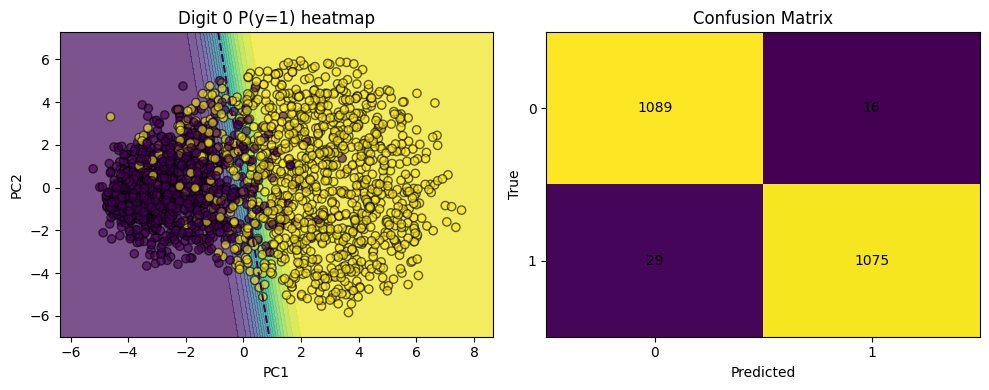


Digit 1 — Acc: 0.980, Prec: 0.972, Rec: 0.988, F1: 0.980
Confusion Matrix:
 [[1225   36]
 [  15 1245]]


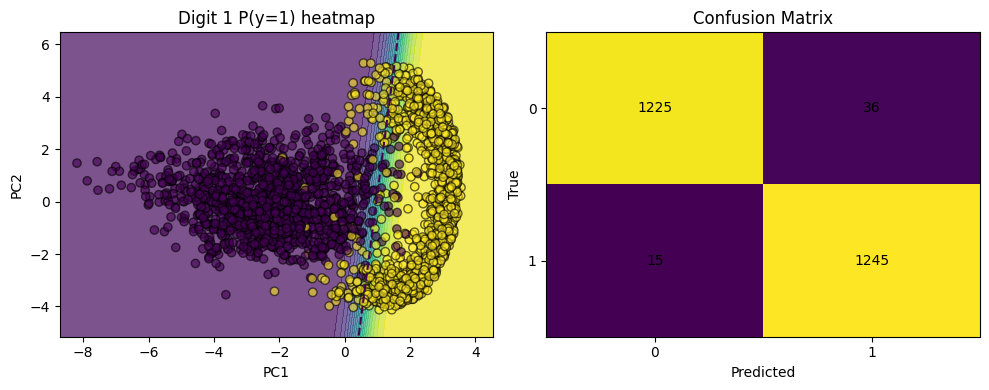


Digit 2 — Acc: 0.940, Prec: 0.950, Rec: 0.929, F1: 0.939
Confusion Matrix:
 [[1064   55]
 [  79 1039]]


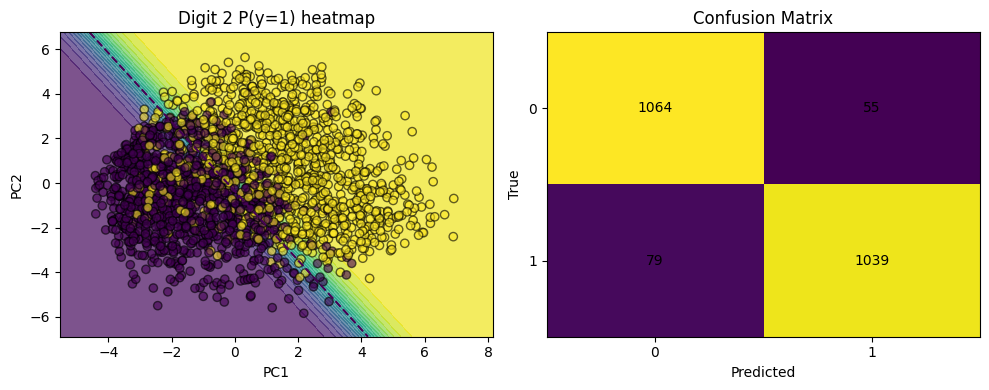


Digit 3 — Acc: 0.930, Prec: 0.934, Rec: 0.926, F1: 0.930
Confusion Matrix:
 [[1068   75]
 [  85 1058]]


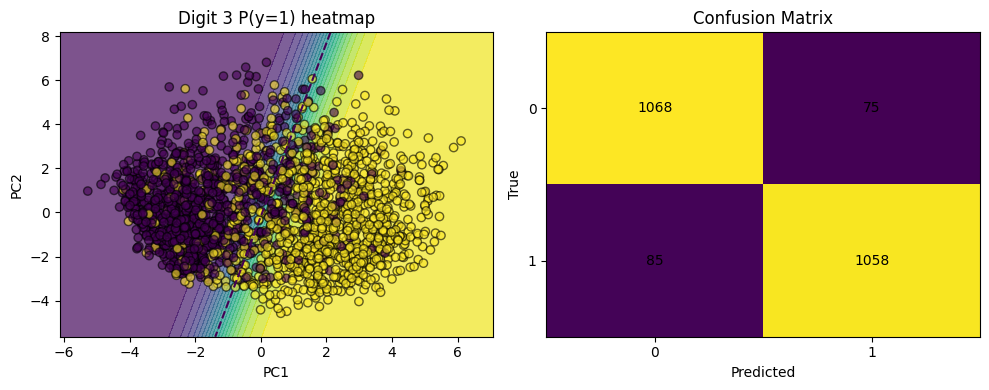


Digit 4 — Acc: 0.966, Prec: 0.964, Rec: 0.967, F1: 0.966
Confusion Matrix:
 [[1053   39]
 [  36 1056]]


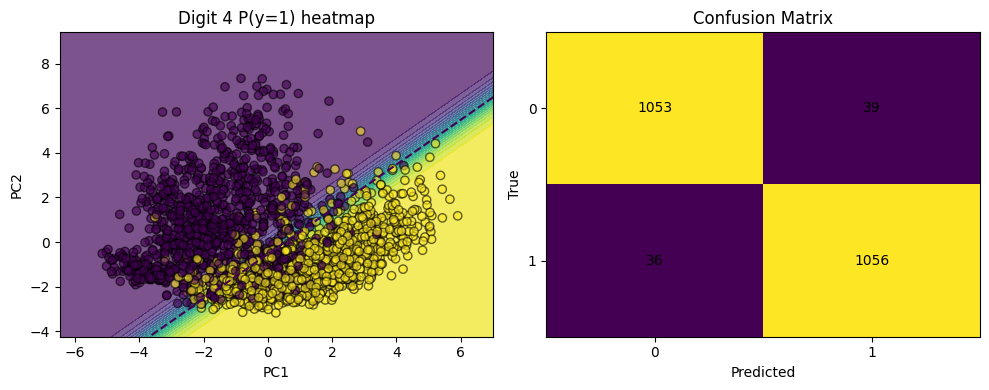


Digit 5 — Acc: 0.932, Prec: 0.928, Rec: 0.936, F1: 0.932
Confusion Matrix:
 [[937  73]
 [ 65 945]]


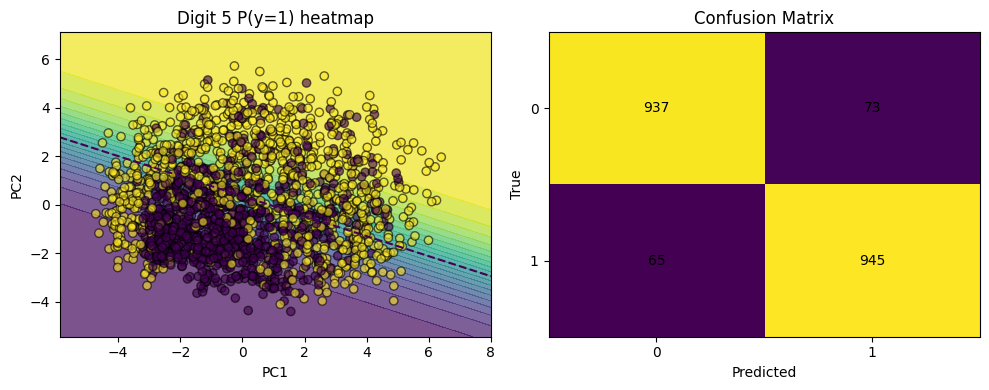


Digit 6 — Acc: 0.967, Prec: 0.966, Rec: 0.968, F1: 0.967
Confusion Matrix:
 [[1064   37]
 [  35 1065]]


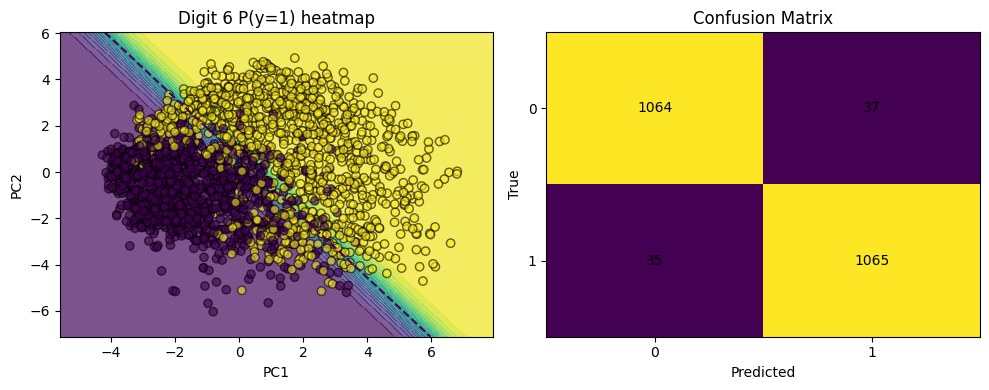


Digit 7 — Acc: 0.965, Prec: 0.965, Rec: 0.965, F1: 0.965
Confusion Matrix:
 [[1126   41]
 [  41 1126]]


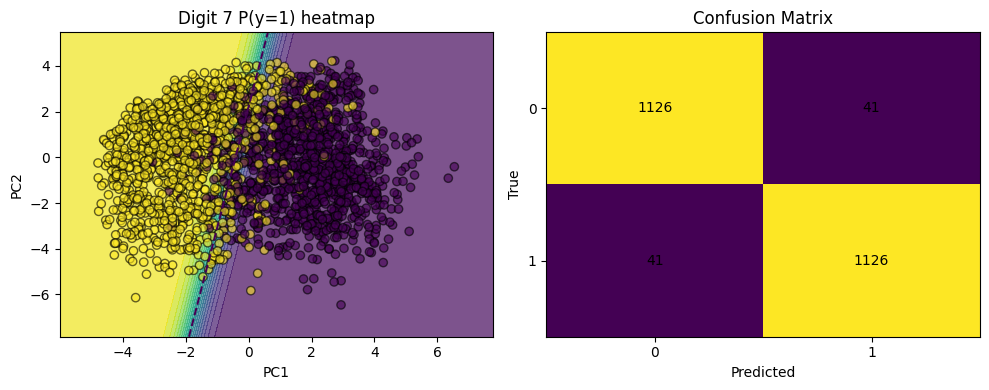


Digit 8 — Acc: 0.909, Prec: 0.909, Rec: 0.910, F1: 0.909
Confusion Matrix:
 [[992 100]
 [ 98 994]]


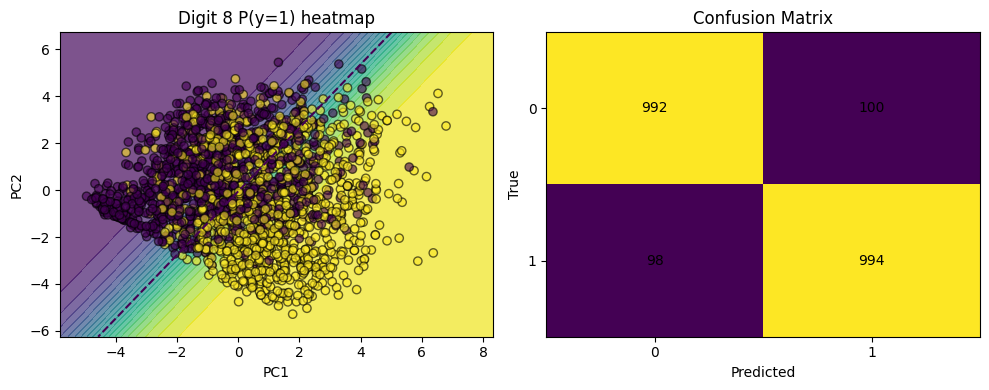


Digit 9 — Acc: 0.935, Prec: 0.931, Rec: 0.940, F1: 0.935
Confusion Matrix:
 [[1036   78]
 [  67 1046]]


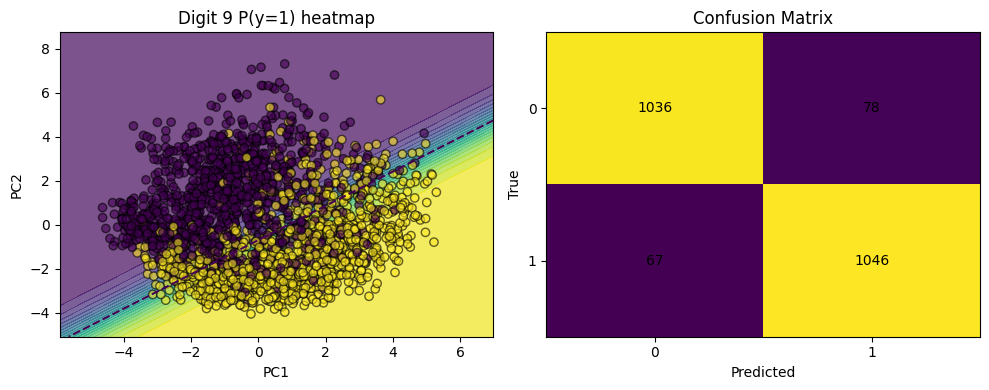

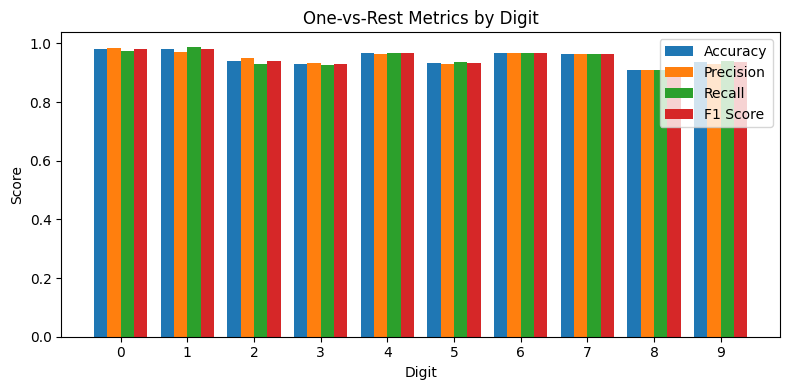

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import (
    accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix
)
from sklearn.model_selection import train_test_split
import joblib

# Load the data
X_train, X_test, y_train, y_test = joblib.load(r'Models and Data splits/data_[SCALED] Train_Test_Splits.pkl')

# Storage for metrics
digits = list(range(10))
accs, precs, recs, f1s = [], [], [], []

for digit in digits:
    # — balance the dataset —
    X_pos = X_train[y_train == digit];  y_pos = np.ones(len(X_pos))
    X_neg = X_train[y_train != digit];  y_neg = np.zeros(len(X_neg))
    
    # Resample the negative class to balance the dataset
    X_neg_bal, y_neg_bal = resample(
        X_neg, y_neg,
        replace=False, n_samples=len(X_pos), random_state=42
    )
    
    X_bal = np.vstack([X_pos, X_neg_bal])
    y_bal = np.concatenate([y_pos, y_neg_bal])

    # — train/test split —
    X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(
        X_bal, y_bal,
        test_size=0.2, random_state=42, stratify=y_bal
    )

    # — fit & save logistic regression model —
    clf = LogisticRegression(solver="saga", max_iter=1000)
    clf.fit(X_train_bal, y_train_bal)
    joblib.dump(clf, f"Models and Data splits/surrogate_digit_{digit}.pkl")
    # — eval on test fold —
    y_pred = clf.predict(X_test_bal)
    accs.append(accuracy_score(y_test_bal, y_pred))
    precs.append(precision_score(y_test_bal, y_pred))
    recs.append(recall_score(y_test_bal, y_pred))
    f1s.append(f1_score(y_test_bal, y_pred))
    cm = confusion_matrix(y_test_bal, y_pred)

    print(f"\nDigit {digit} — Acc: {accs[-1]:.3f}, Prec: {precs[-1]:.3f}, "
          f"Rec: {recs[-1]:.3f}, F1: {f1s[-1]:.3f}")
    print("Confusion Matrix:\n", cm)

    # — decision boundary & probability heatmap in 2D PCA space —
    pca = PCA(n_components=2).fit(X_train_bal)
    X_tr2 = pca.transform(X_train_bal)
    X_te2 = pca.transform(X_test_bal)

    # Create a grid in PCA space
    x_min, x_max = X_tr2[:,0].min()-1, X_tr2[:,0].max()+1
    y_min, y_max = X_tr2[:,1].min()-1, X_tr2[:,1].max()+1
    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )
    # Back to the original space to get P(digit)
    grid_orig = pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()])
    prob_pos = clf.predict_proba(grid_orig)[:,1].reshape(xx.shape)

    # Plot results
    fig, axs = plt.subplots(1, 2, figsize=(10,4))

    # 1) probability heatmap + 0.5 contour
    pcm = axs[0].contourf(xx, yy, prob_pos, levels=20, alpha=0.7)
    axs[0].contour(xx, yy, prob_pos, levels=[0.5], linestyles='--')
    axs[0].scatter(
        X_te2[:,0], X_te2[:,1],
        c=y_test_bal, edgecolor='k', alpha=0.6
    )
    axs[0].set_title(f"Digit {digit} P(y=1) heatmap")
    axs[0].set_xlabel("PC1"); axs[0].set_ylabel("PC2")

    # 2) confusion matrix heatmap
    im = axs[1].imshow(cm, interpolation='nearest', aspect='auto')
    for (i, j), v in np.ndenumerate(cm):
        axs[1].text(j, i, f"{v}", ha='center', va='center')
    axs[1].set_xticks([0,1]); axs[1].set_yticks([0,1])
    axs[1].set_xlabel("Predicted"); axs[1].set_ylabel("True")
    axs[1].set_title("Confusion Matrix")

    plt.tight_layout()
    plt.show()

# — Finally: bar chart of metrics across all digits —
fig, ax = plt.subplots(figsize=(8,4))
x = np.arange(len(digits))
w = 0.2
ax.bar(x - 1.5*w, accs,    width=w, label="Accuracy")
ax.bar(x -   0.5*w, precs,  width=w, label="Precision")
ax.bar(x +   0.5*w, recs,   width=w, label="Recall")
ax.bar(x + 1.5*w, f1s,     width=w, label="F1 Score")
ax.set_xticks(x); ax.set_xticklabels(digits)
ax.set_xlabel("Digit"); ax.set_ylabel("Score")
ax.set_title("One-vs-Rest Metrics by Digit")
ax.legend(loc="best")
plt.tight_layout()
plt.show()


# Sampling
### Cross Model Sampling

### On train/seen Data

In [3]:
import pathlib
import random
import numpy as np
from collections import defaultdict
import joblib
import torch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Config
ROOT = pathlib.Path("Models and Data splits")
DATA_PREFIX = "data_"
MODEL_PREFIX = "model_"
PHASE = "train"
RANDOM_SEED = 42
SAMPLES_PER_DIGIT = 100
BATCH_SIZE = 64
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load MNIST splits
splits_f = ROOT / f"{DATA_PREFIX}[ORIGINAL] Train_Test_Splits.pkl"
X_train_orig, X_test_orig, y_train, y_test = joblib.load(str(splits_f))
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)

# 2) Fit StandardScaler on X_test (for CNNSca and MLP1LSca)
scaler = StandardScaler()
X_test_scaled = X_test_orig.astype(np.float32) / 255.0
scaler.fit(X_test_scaled)

# 3) Torch model loader
def load_torch_model(tag: str):
    model_path = ROOT / f"{MODEL_PREFIX}{tag}.pt"
    model = torch.jit.load(str(model_path), map_location="cpu").eval()

    def fn(batch_np: np.ndarray) -> np.ndarray:
        arr = batch_np.astype(np.float32)

        if tag.endswith("Sca"):
            arr = scaler.transform(arr)
        else:
            arr = arr / 255.0

        x = torch.tensor(arr, dtype=torch.float32)
        if tag.startswith("CNN"):
            x = x.reshape(-1, 28, 28).unsqueeze(1)
        else:
            x = x.reshape(len(batch_np), -1)

        with torch.no_grad():
            logits = model(x)
        return logits.cpu().numpy()
    return fn

# 4) Sklearn model loader
def load_sklearn_model(tag: str):
    model_path = ROOT / f"{MODEL_PREFIX}{tag}.pkl"
    clf = joblib.load(str(model_path))

    def fn(batch_np: np.ndarray) -> np.ndarray:
        flat = batch_np.reshape(len(batch_np), -1) / 255.0
        if hasattr(clf, "predict_proba"):
            return clf.predict_proba(flat)
        preds = clf.predict(flat)
        oh = np.zeros((len(preds), 10), dtype=np.float32)
        oh[np.arange(len(preds)), preds] = 1.0
        return oh
    return fn

# 5) Define model tags
neuron_sizes = [32, 64, 128, 256]
model_tags = [f"MLP1L_{n}" for n in neuron_sizes] + \
             [f"MLP2L_{n}" for n in neuron_sizes] + \
             ["CNN", "CNNSca", "MLP1LSca", "SVM", "KNN", "RF"]

# 6) Load all models
models = {}
for tag in model_tags:
    if tag in {"SVM", "KNN", "RF"}:
        models[tag] = load_sklearn_model(tag)
    else:
        models[tag] = load_torch_model(tag)

# 7) Sampling logic
needed = {d: SAMPLES_PER_DIGIT for d in range(10)}
chosen_imgs = defaultdict(list)
chosen_lbls = defaultdict(list)
logits_out = {tag: defaultdict(list) for tag in models}

indices_by_digit = {d: np.where(y_train == d)[0].tolist() for d in range(10)}
remaining = {d: set(idxs) for d, idxs in indices_by_digit.items()}
rng = random.Random(RANDOM_SEED)

progress = tqdm(total=10 * SAMPLES_PER_DIGIT, desc="Sampling unanimous examples")

while any(needed[d] > 0 for d in range(10)):
    for d in range(10):
        if needed[d] == 0 or not remaining[d]:
            continue

        # Sample a batch of candidates
        candidate_indices = rng.sample(list(remaining[d]), min(BATCH_SIZE, len(remaining[d])))
        batch_imgs = np.array([X_train_orig[i] for i in candidate_indices])
        batch_lbls = np.array([y_train[i] for i in candidate_indices])

        # Gather predictions from all models
        all_model_logits = {tag: fn(batch_imgs) for tag, fn in models.items()}

        # For each sample in batch
        for i, idx in enumerate(candidate_indices):
            pred_correct = all(
                all_model_logits[tag][i].argmax() == batch_lbls[i]
                for tag in models
            )
            if pred_correct:
                img = batch_imgs[i]
                lbl = batch_lbls[i]
                chosen_imgs[d].append(img)
                chosen_lbls[d].append(lbl)
                for tag in models:
                    logits_out[tag][d].append(all_model_logits[tag][i])
                needed[d] -= 1
                progress.update(1)
            remaining[d].discard(idx)

            if needed[d] == 0:
                break

progress.close()

# 8) Save final unanimous dataset
X_final = np.stack([img for d in range(10) for img in chosen_imgs[d]])
y_final = np.array([lbl for d in range(10) for lbl in chosen_lbls[d]], np.int64)

save_f = ROOT / f"Sampled_AllModels_{PHASE}.pkl"
joblib.dump((X_final, y_final, logits_out), str(save_f))

print(f"✅ Saved {SAMPLES_PER_DIGIT * 10} unanimous samples → {save_f}")
for d in range(10):
    print(f"Digit {d}: {len(chosen_imgs[d])} images ✓")


Sampling unanimous examples: 100%|█████████████████████████████████████████████████| 1000/1000 [00:47<00:00, 21.21it/s]


✅ Saved 1000 unanimous samples → Models and Data splits\Sampled_AllModels_train.pkl
Digit 0: 100 images ✓
Digit 1: 100 images ✓
Digit 2: 100 images ✓
Digit 3: 100 images ✓
Digit 4: 100 images ✓
Digit 5: 100 images ✓
Digit 6: 100 images ✓
Digit 7: 100 images ✓
Digit 8: 100 images ✓
Digit 9: 100 images ✓


### On test/unseen data

In [7]:
import pathlib
import random
import numpy as np
from collections import defaultdict
import joblib
import torch
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

# ─────────────────────────────────────────────────────────────────────────────
# Config
ROOT = pathlib.Path("Models and Data splits")
DATA_PREFIX = "data_"
MODEL_PREFIX = "model_"
PHASE = "test"  # Changed to test
RANDOM_SEED = 42
SAMPLES_PER_DIGIT = 100
BATCH_SIZE = 64
# ─────────────────────────────────────────────────────────────────────────────

# 1) Load MNIST splits
splits_f = ROOT / f"{DATA_PREFIX}[ORIGINAL] Train_Test_Splits.pkl"
X_train_orig, X_test_orig, y_train, y_test = joblib.load(str(splits_f))
y_train = np.asarray(y_train, dtype=np.int64)
y_test = np.asarray(y_test, dtype=np.int64)

# 2) Fit StandardScaler on X_test (for CNNSca and MLP1LSca)
scaler = StandardScaler()
X_test_scaled = X_test_orig.astype(np.float32) / 255.0
scaler.fit(X_test_scaled)

# 3) Torch model loader
def load_torch_model(tag: str):
    model_path = ROOT / f"{MODEL_PREFIX}{tag}.pt"
    model = torch.jit.load(str(model_path), map_location="cpu").eval()

    def fn(batch_np: np.ndarray) -> np.ndarray:
        arr = batch_np.astype(np.float32)

        if tag.endswith("Sca"):
            arr = scaler.transform(arr)
        else:
            arr = arr / 255.0

        x = torch.tensor(arr, dtype=torch.float32)
        if tag.startswith("CNN"):
            x = x.reshape(-1, 28, 28).unsqueeze(1)
        else:
            x = x.reshape(len(batch_np), -1)

        with torch.no_grad():
            logits = model(x)
        return logits.cpu().numpy()
    return fn

# 4) Sklearn model loader
def load_sklearn_model(tag: str):
    model_path = ROOT / f"{MODEL_PREFIX}{tag}.pkl"
    clf = joblib.load(str(model_path))

    def fn(batch_np: np.ndarray) -> np.ndarray:
        flat = batch_np.reshape(len(batch_np), -1) / 255.0
        if hasattr(clf, "predict_proba"):
            return clf.predict_proba(flat)
        preds = clf.predict(flat)
        oh = np.zeros((len(preds), 10), dtype=np.float32)
        oh[np.arange(len(preds)), preds] = 1.0
        return oh
    return fn

# 5) Define model tags
neuron_sizes = [32, 64, 128, 256]
model_tags = [f"MLP1L_{n}" for n in neuron_sizes] + \
             [f"MLP2L_{n}" for n in neuron_sizes] + \
             ["CNN", "CNNSca", "MLP1LSca", "SVM", "KNN", "RF"]

# 6) Load all models
models = {}
for tag in model_tags:
    if tag in {"SVM", "KNN", "RF"}:
        models[tag] = load_sklearn_model(tag)
    else:
        models[tag] = load_torch_model(tag)

# 7) Sampling logic — from test set
needed = {d: SAMPLES_PER_DIGIT for d in range(10)}
chosen_imgs = defaultdict(list)
chosen_lbls = defaultdict(list)
logits_out = {tag: defaultdict(list) for tag in models}

# Use test set for sampling
indices_by_digit = {d: np.where(y_test == d)[0].tolist() for d in range(10)}
remaining = {d: set(idxs) for d, idxs in indices_by_digit.items()}
rng = random.Random(RANDOM_SEED)

progress = tqdm(total=10 * SAMPLES_PER_DIGIT, desc="Sampling unanimous test examples")

while any(needed[d] > 0 for d in range(10)):
    for d in range(10):
        if needed[d] == 0 or not remaining[d]:
            continue

        candidate_indices = rng.sample(list(remaining[d]), min(BATCH_SIZE, len(remaining[d])))
        batch_imgs = np.array([X_test_orig[i] for i in candidate_indices])
        batch_lbls = np.array([y_test[i] for i in candidate_indices])

        # Get predictions from all models
        all_model_logits = {tag: fn(batch_imgs) for tag, fn in models.items()}

        for i, idx in enumerate(candidate_indices):
            pred_correct = all(
                all_model_logits[tag][i].argmax() == batch_lbls[i]
                for tag in models
            )
            if pred_correct:
                img = batch_imgs[i]
                lbl = batch_lbls[i]
                chosen_imgs[d].append(img)
                chosen_lbls[d].append(lbl)
                for tag in models:
                    logits_out[tag][d].append(all_model_logits[tag][i])
                needed[d] -= 1
                progress.update(1)
            remaining[d].discard(idx)

            if needed[d] == 0:
                break

progress.close()

# 8) Save final unanimous dataset
X_final = np.stack([img for d in range(10) for img in chosen_imgs[d]])
y_final = np.array([lbl for d in range(10) for lbl in chosen_lbls[d]], np.int64)

save_f = ROOT / f"Sampled_AllModels_{PHASE}.pkl"
joblib.dump((X_final, y_final, logits_out), str(save_f))

print(f"✅ Saved {SAMPLES_PER_DIGIT * 10} unanimous samples → {save_f}")
for d in range(10):
    print(f"Digit {d}: {len(chosen_imgs[d])} images ✓")


Sampling unanimous test examples: 100%|████████████████████████████████████████████| 1000/1000 [00:46<00:00, 21.49it/s]


✅ Saved 1000 unanimous samples → Models and Data splits\Sampled_AllModels_test.pkl
Digit 0: 100 images ✓
Digit 1: 100 images ✓
Digit 2: 100 images ✓
Digit 3: 100 images ✓
Digit 4: 100 images ✓
Digit 5: 100 images ✓
Digit 6: 100 images ✓
Digit 7: 100 images ✓
Digit 8: 100 images ✓
Digit 9: 100 images ✓
